In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib notebook

import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import coronavirus as cv
from coronavirus import *

configure_matplotlib()

In [2]:
ts = load_timeseries()

----
# Today Query

In [3]:
today_locs = ['USA', 'CAN', 'IRL', 'ITA', 'ESP', 'British Columbia, CAN', 'NY, USA', 'WA, USA']
today_cols = ['date', 'location', 'cases', 'deaths']

cur_day = np.datetime64('today') - np.timedelta64(1, 'D')
prev_day = np.datetime64('today') - np.timedelta64(2, 'D')

today_query = ts.location.isin(today_locs)
today_query &= ts.date.isin([cur_day, prev_day])

todaytable = ts[today_query][today_cols]
todaytable.date = todaytable.date.astype(str).str[:10]
cur_day = str(cur_day)[:10]
prev_day = str(prev_day)[:10]

def today_summary(value):
    table = todaytable.pivot(index='location', columns='date', values='cases')
    table['delta'] = table[cur_day] - table[prev_day]
    table = table.sort_values(by=cur_day, ascending=False)
    return table.style.format({cur_day: '{:,.0f}', prev_day: '{:,.0f}', 'delta': '{:+,.0f}'})

----
# Cases

In [4]:
today_summary('cases')

date,2020-03-24,2020-03-25,delta
location,,,
ITA,"69,176","74,386","+5,210"
USA,"53,192","64,180","+10,988"
ESP,"39,673","47,610","+7,937"
"NY, USA","25,663","30,811","+5,148"
CAN,"1,959","3,385","+1,426"
"WA, USA","2,469","2,580",+111
IRL,"1,329","1,564",+235
"British Columbia, CAN",617,659,+42


----
# Deaths

In [5]:
today_summary('deaths')

date,2020-03-24,2020-03-25,delta
location,,,
ITA,"69,176","74,386","+5,210"
USA,"53,192","64,180","+10,988"
ESP,"39,673","47,610","+7,937"
"NY, USA","25,663","30,811","+5,148"
CAN,"1,959","3,385","+1,426"
"WA, USA","2,469","2,580",+111
IRL,"1,329","1,564",+235
"British Columbia, CAN",617,659,+42


----
# Locations of Interest

In [53]:
locations_of_interest = {
    'WA':    ('WA, USA',          'teal'),
    'BC':    ('British Columbia', 'slateblue'),
    'Italy': ('Italy',            'chocolate'),
    'NY':    ('NY, USA',          'tomato'),
    'UK':    ('UK',               'royalblue'),
    'FL':    ('FL, USA',          'darkorange'),
    'IRL':   ('Ireland',          'forestgreen'),
    'Spain': ('Spain',            'goldenrod'),
    'USA':   ('USA',              'red')
}
tables_interest = { k:location(loc) for k, (loc, _) in locations_of_interest.items() }
cv.loc_colors = {k:col for k, (_, col) in locations_of_interest.items() }

hotspots = ['Italy', 'Spain', 'UK', 'NY', 'FL']
nearspots = ['BC', 'WA', 'IRL']

tables_hot = { loc:tables_interest[loc] for loc in hotspots }
tables_near = { loc:tables_interest[loc] for loc in nearspots }

----
# Locations of Interest
## Days Since 75 Cases

<IPython.core.display.Javascript object>


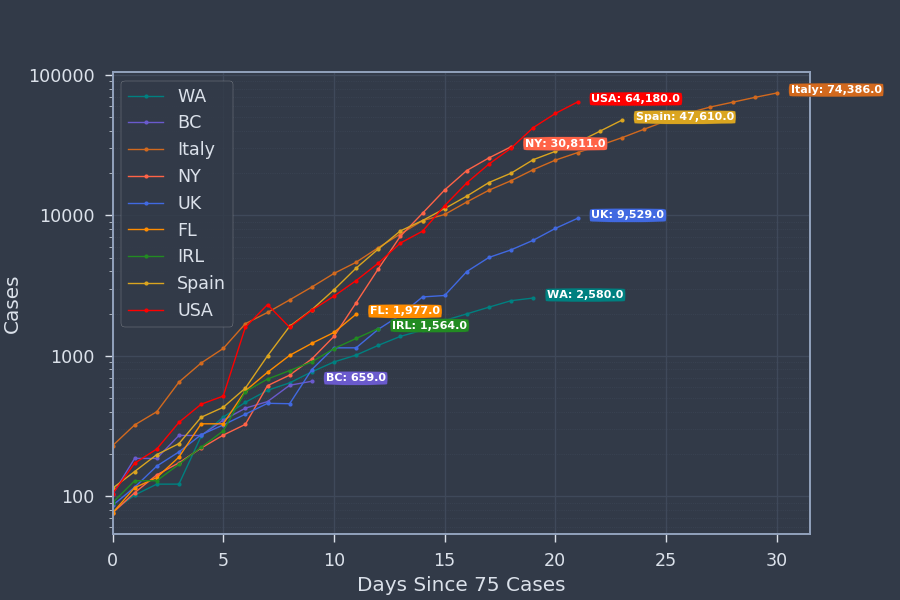

<IPython.core.display.Javascript object>


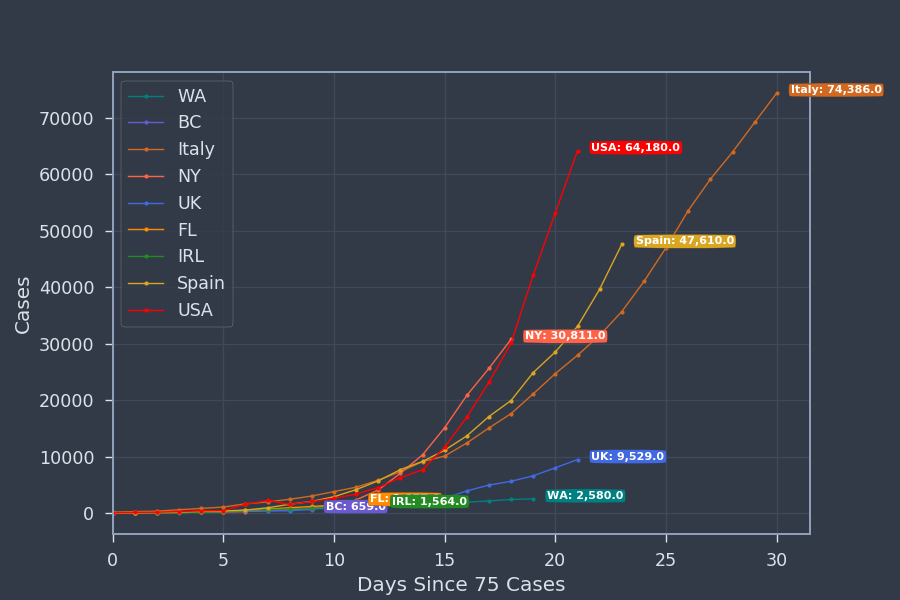

In [54]:
CovPlot75(tables_interest)
CovPlot75(tables_interest, scale='linear')

----
# Hotspots
## Days Since 75 Cases

<IPython.core.display.Javascript object>


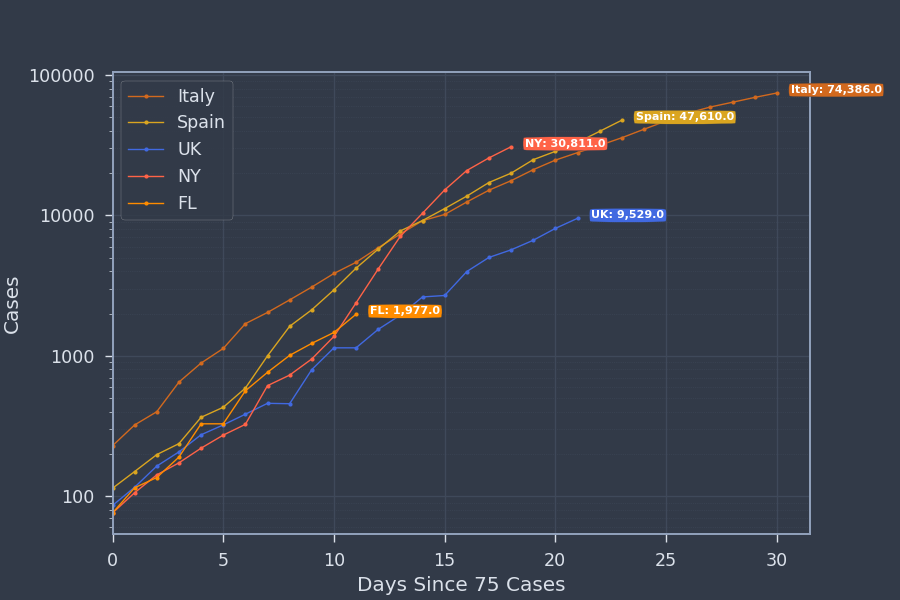

<IPython.core.display.Javascript object>


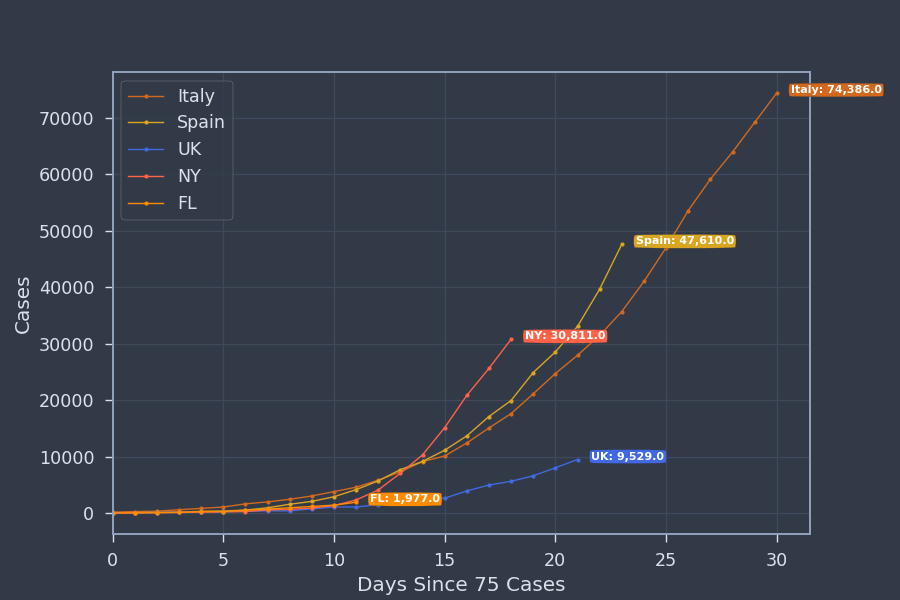

In [55]:
CovPlot75(tables_hot)
CovPlot75(tables_hot, scale='linear')

----
# Closely Tracked Spots
## Days Since 75 Cases

<IPython.core.display.Javascript object>


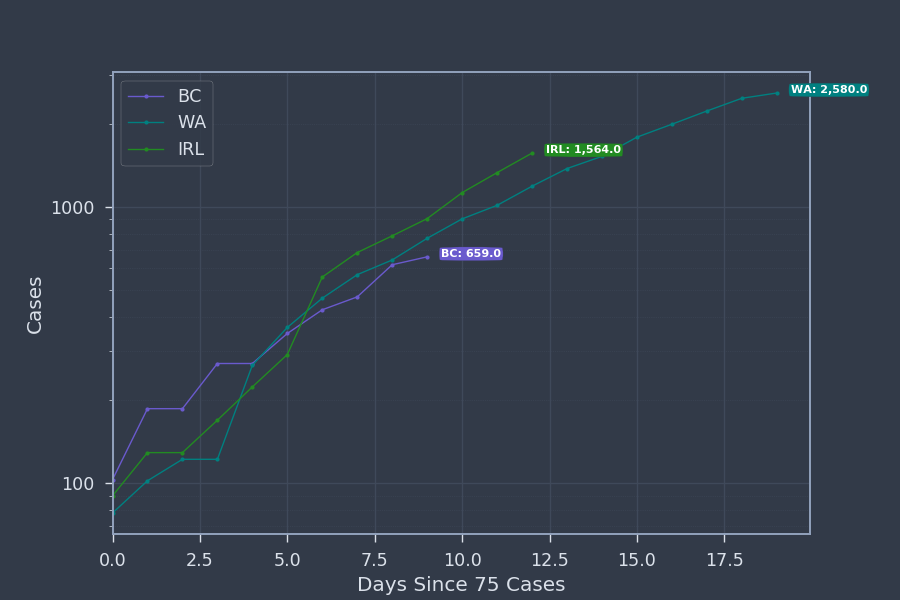

<IPython.core.display.Javascript object>


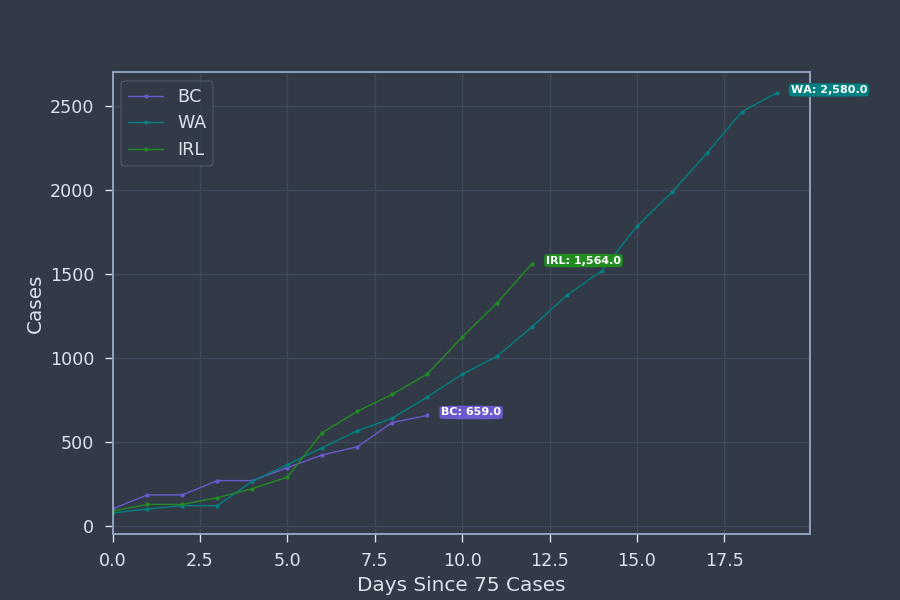

In [9]:
CovPlot75(tables_near)
CovPlot75(tables_near, scale='linear')

----
# Locations of Interest
## Date Plot

<IPython.core.display.Javascript object>


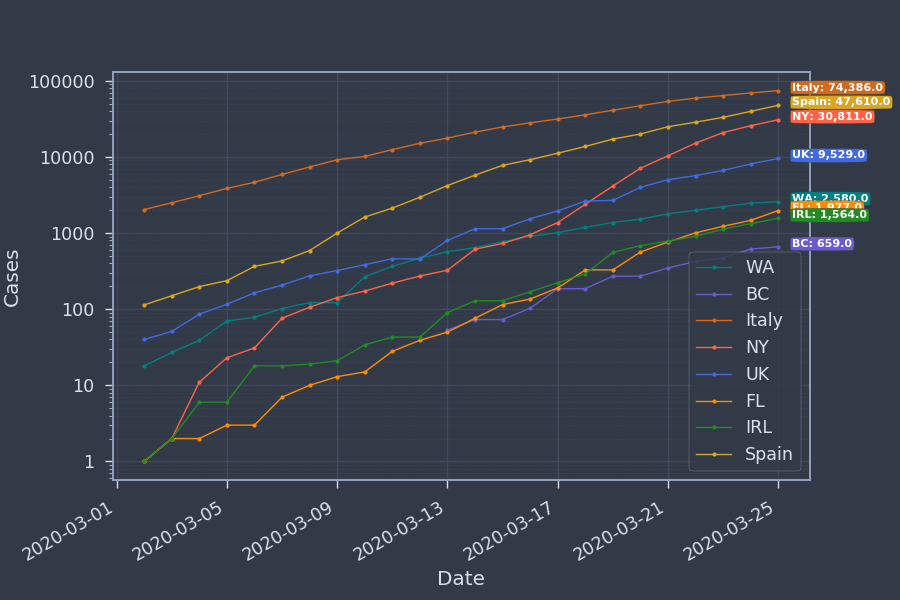

<IPython.core.display.Javascript object>


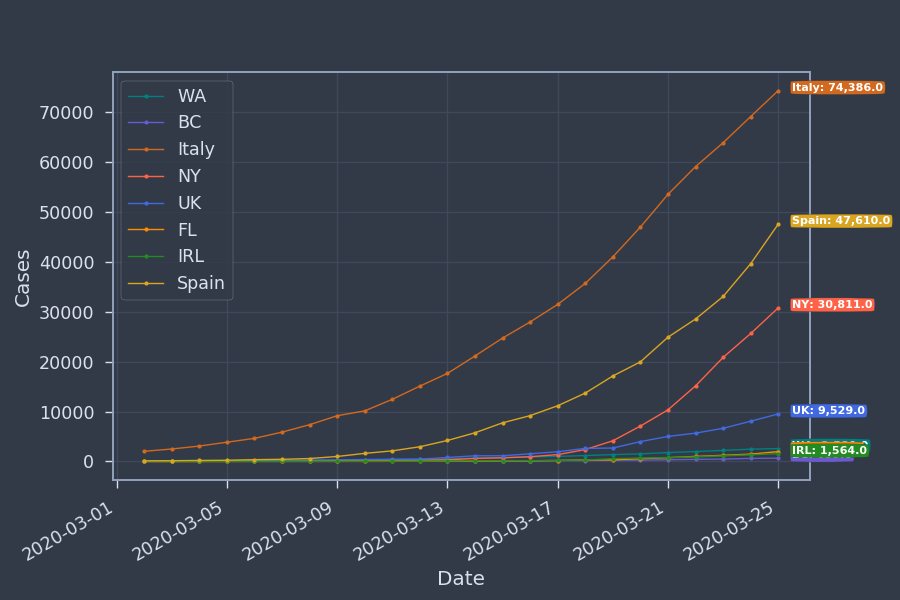

In [10]:
CovPlot(tables_interest)
CovPlot(tables_interest, scale='linear')

----
# Hotspots
## Date Plot

<IPython.core.display.Javascript object>


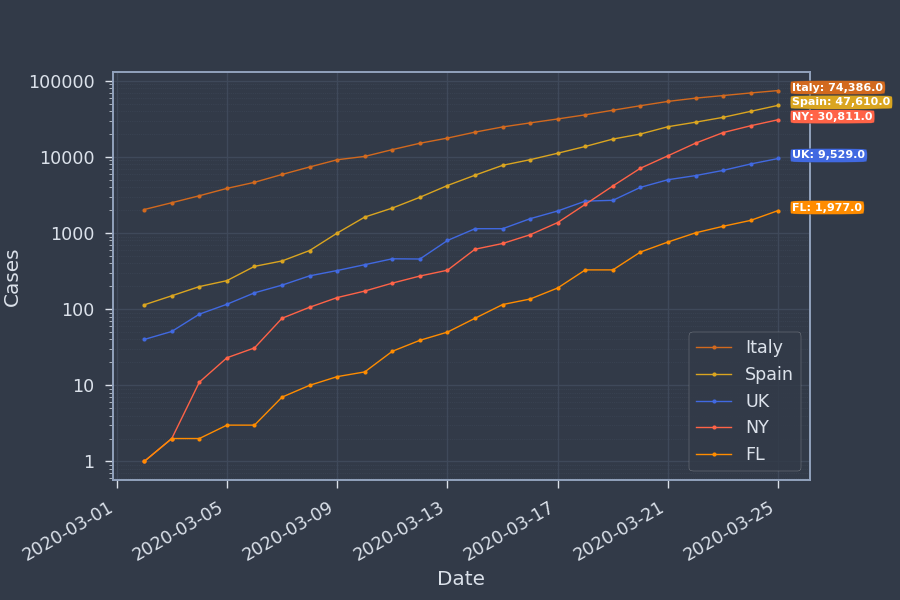

<IPython.core.display.Javascript object>


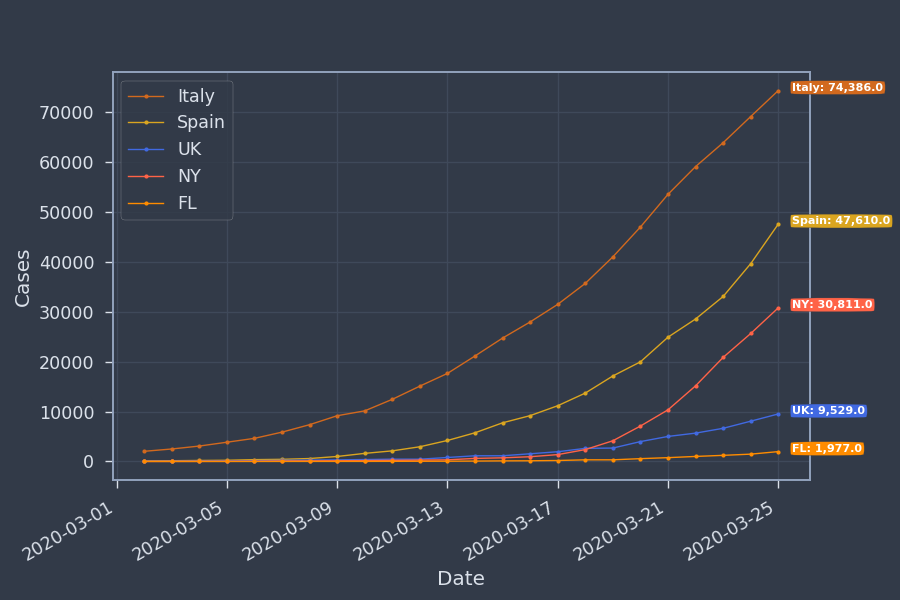

In [11]:
CovPlot(tables_hot)
CovPlot(tables_hot, scale='linear')

----
# Closely Tracked Spots
## Date Plot

<IPython.core.display.Javascript object>


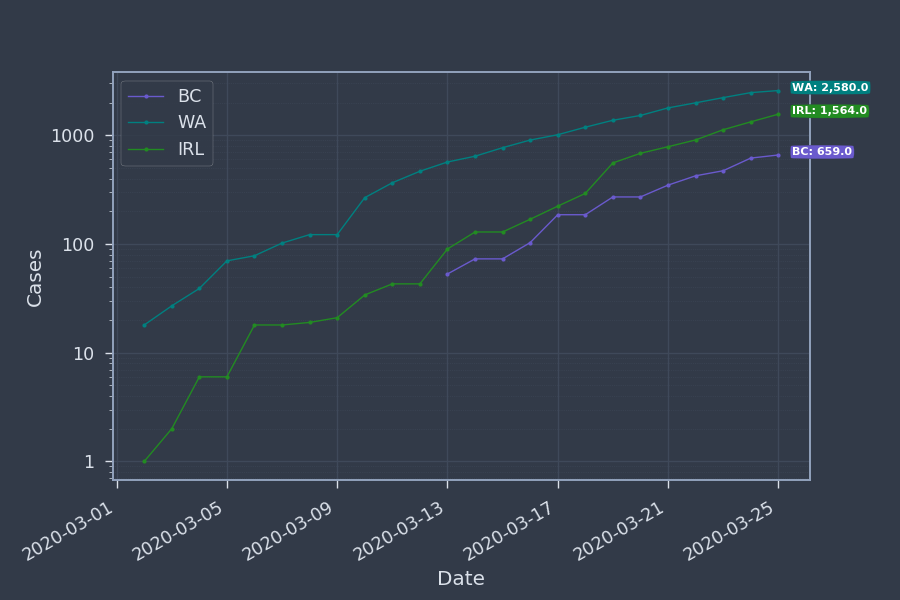

<IPython.core.display.Javascript object>


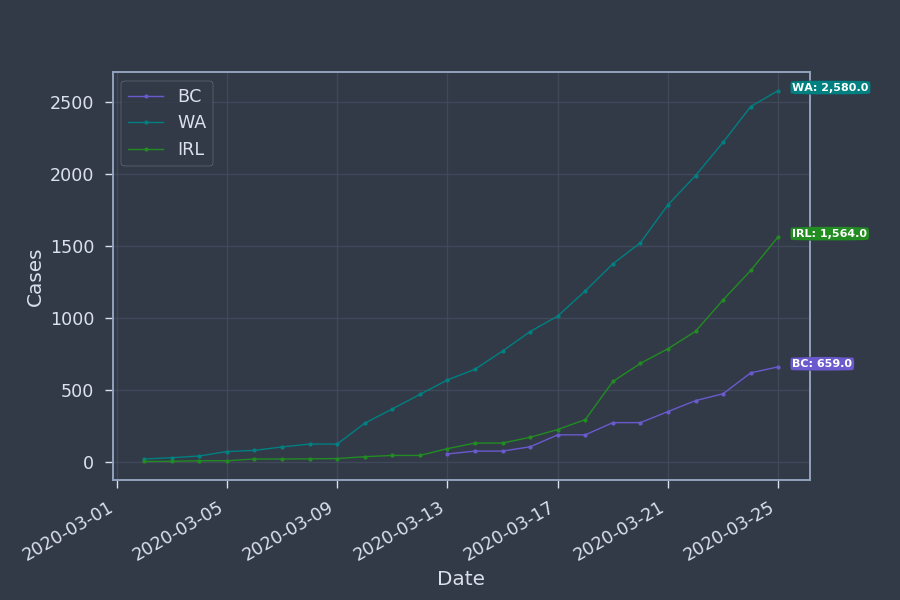

In [12]:
CovPlot(tables_near)
CovPlot(tables_near, scale='linear')

----
# Canadian Provinces

In [13]:
province_locs = {
    ('AB', 'Alberta, CAN'),
    ('BC', 'British Columbia, CAN'),
    ('MB', 'Manitoba, CAN'),
    ('NB', 'New Brunswick, CAN'),
    ('SK', 'Saskatchewan, CAN'),
    ('NS', 'Nova Scotia, CAN'),
    ('ON', 'Ontario, CAN'),
    ('QC', 'Quebec, CAN'),
}
provinces = { key:location(loc) for (key,loc) in province_locs }

----
# Canadian Provinces
## Date Plot

<IPython.core.display.Javascript object>


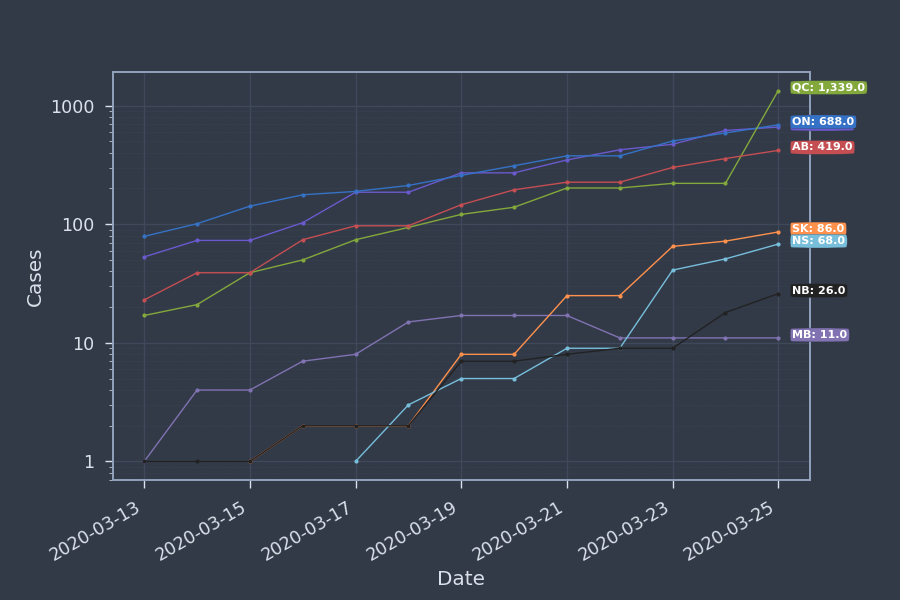

<IPython.core.display.Javascript object>


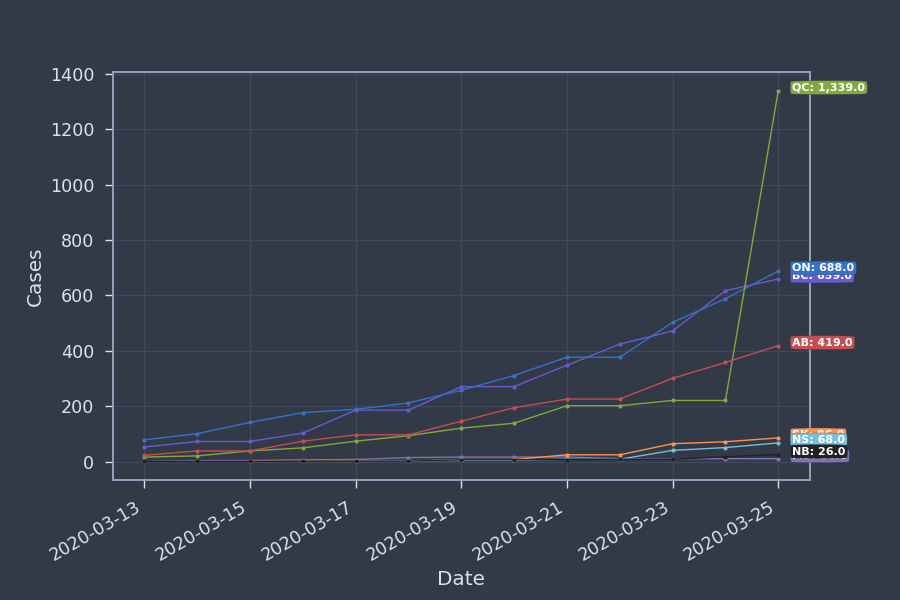

In [14]:
CovPlot(provinces, legend=False)
CovPlot(provinces, scale='linear', legend=False)

----
# Canadian Provinces
## Days Since 75 Cases

<IPython.core.display.Javascript object>


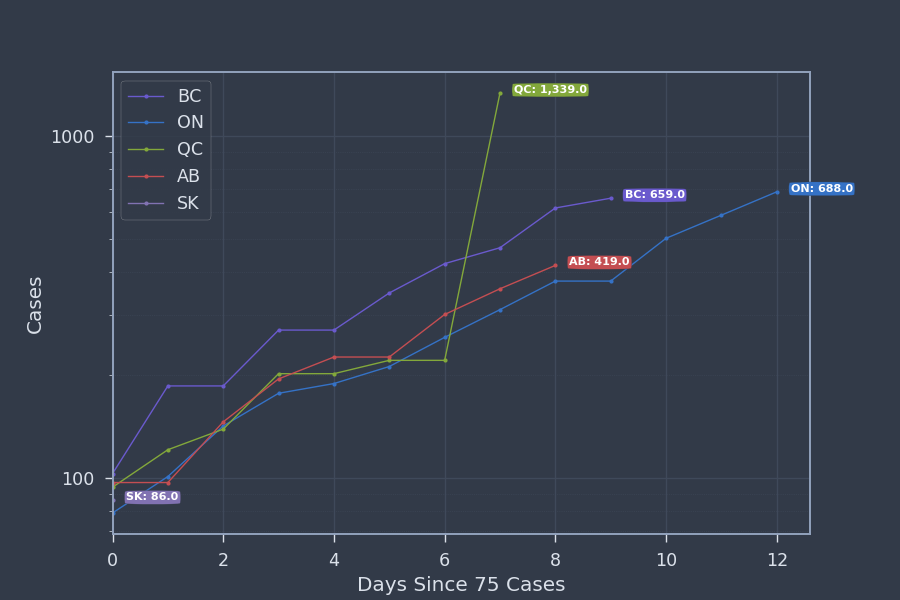

<IPython.core.display.Javascript object>


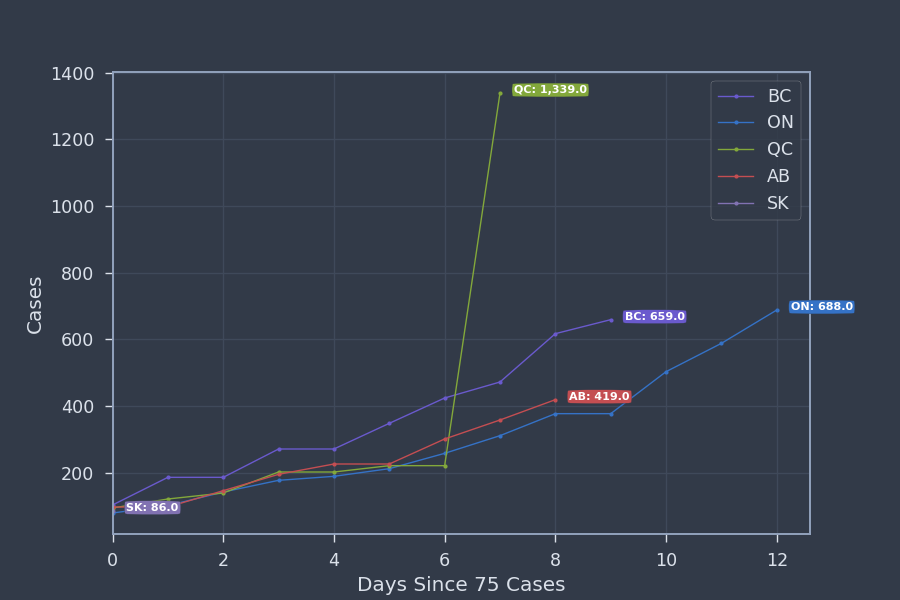

In [15]:
CovPlot75(provinces, legend=False)
CovPlot75(provinces, scale='linear', legend=False)

----
# New York vs Lombardy

In [16]:
ny_vs_lom = {
    'New York': location('NY, USA'),
    'Lombardy': location('Lombardia, ITA'),
}

----
# New York vs Lombary
## Days Since 75 Cases

<IPython.core.display.Javascript object>


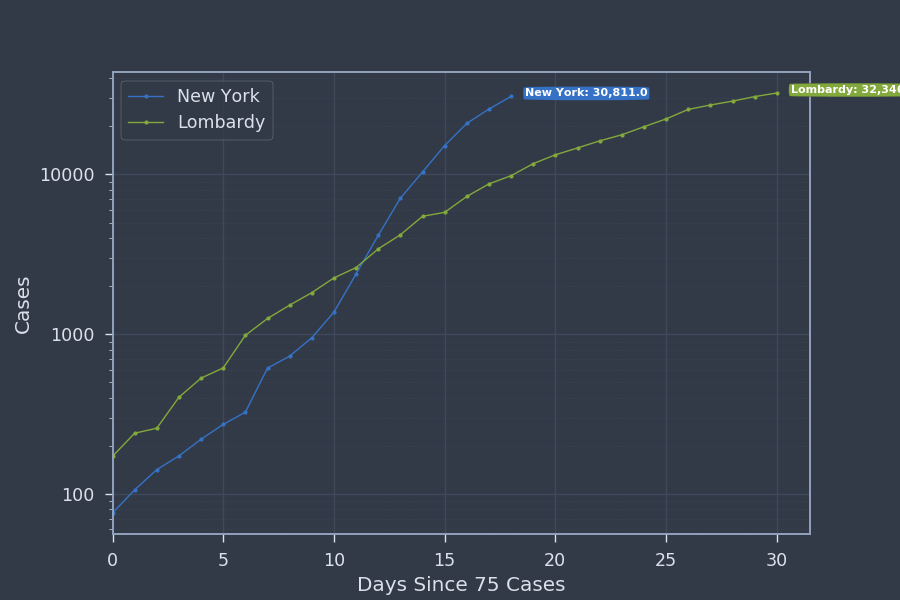

<IPython.core.display.Javascript object>


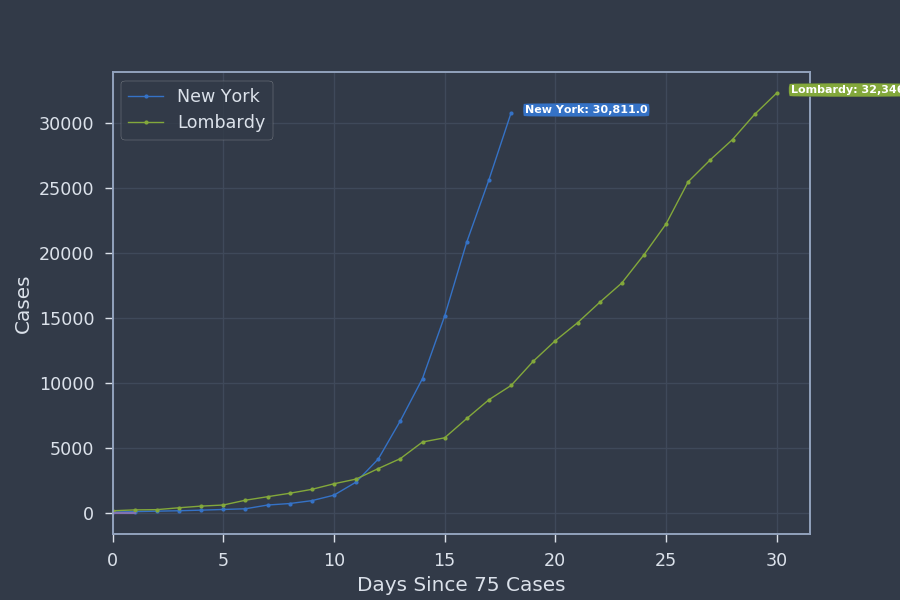

In [17]:
CovPlot75(ny_vs_lom)
CovPlot75(ny_vs_lom, scale='linear')

<IPython.core.display.Javascript object>


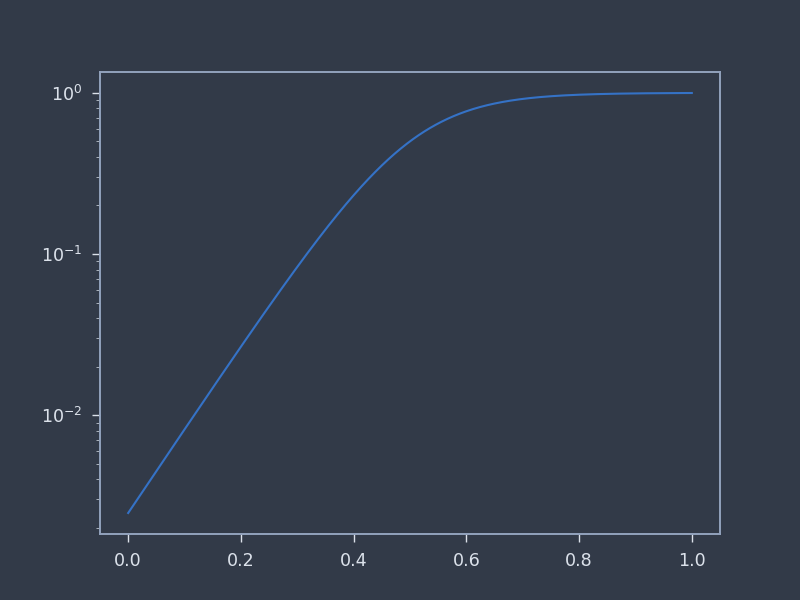

In [52]:
def sigmoid(x, x0, L, k):
    return L / (1 + np.exp((0 - k) * (x - x0)))

xs1 = np.linspace(0, 1, 1000)
#xs2 = np.linspace(1, 2, 1000)
ys1 = sigmoid(xs1, x0=0.5, L=1, k=12)
#ys2 = 1 - sigmoid(xs2, x0=1.5, L=1, k=12)

xs = xs1#np.append(xs1, xs2)
ys = ys1#np.append(ys1, ys2)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.plot(xs, ys)
ax.set_yscale('log')